<h1 align="center">Volume 3: Data Augmentation.</h1>

    NAME Quin Daly
    Section #
    DATE 10/19/2021

In [389]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn import datasets
from imageio import imread
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import librosa
import librosa.display
from librosa.effects import time_stretch

<h2 align="center">Image Augmentation</h2>

<h3 align="center">Problem 1</h3>

In [147]:
def translate(images, A, B): 
    """Returns each image translated by a random amount (a,b), where
    a~Uniform(-A,A) and b~Uniform(-B,B). The resulting image should be cropped
    to be of size (d1,d2). Note that this translation will leave a border on
    two sides of the image. Fill the empty border with the parts that were cropped
    off the opposite sides.
        Parameters:
            images (d1,d2): d1 x d2 array 
            A (float): horizontal translation parameter
            B (float): vertical translation parameter
        Returns:
            translated_image (d1,d2): array of translated images
    """
    # Get the translations
    a = np.random.uniform(-1*A, A)
    b = np.random.uniform(-1*B, B)
    
    d1, d2 = images.shape
      
    # Get coordinate pts for each pixel in image
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    # Translate coordinate matrix by (a,b)
    new_coords = coords + np.array([a,b]).reshape((2,1))
    new_coords = new_coords.astype(int)
    x,y = new_coords.reshape((2,d1,d2), order='F')
    translated_image = np.take(images, x+d1*y, mode='wrap').reshape((d1,d2))
    
    return translated_image

    
    
def rotate(images, theta): 
    """ Returns an image rotated by a random amount t~Uniform(-theta,theta).
    The resulting image should be cropped to be the same size as the original,
    and any blank parts should be filled with one of the parts cropped off the
    other side.
        Parameters:
            images (d1,d2): d1 x d2 array
            theta (float): largest acceptable rotation angle
        Returns:
            rotated_image (d1,d2): array of rotated image
    """
    # Get the translation parameter
    theta = np.random.uniform(-1*theta, theta)
    d1, d2 = images.shape
      
    # Get coordinate pts for each pixel in image
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    # Rotate coordinate matrix by rotation matrix
    rotation_matrix = np.array([[np.cos(theta), -1*np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    new_coords = rotation_matrix @ coords
    new_coords = new_coords.astype(int)
    x,y = new_coords.reshape((2,d1,d2), order='F')
    rotated_image = np.take(images, x+d1*y, mode='wrap').reshape((d1,d2))
    
    return rotated_image
    

    
def skew(images, A): 
    """ Returns an image with the linear transformation [[1,a],[0,1]] applied,
    where a~Uniform(-A,A). Crop the parts that go outside the image boundaries
    and fill missing areas with the appropriate cropped piece.
        Parameters:
            images (d1,d2): d1 x d2 array
            A (float): skew parameter
        Returns:
            skewed_image (d1,d2): array of skewed image
    """
    # Get the translation parameter
    a = np.random.uniform(0, A)
    d1, d2 = images.shape
      
    # Get coordinate pts for each pixel in image
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    # Transform coordinate matrix by skew matrix
    skew_matrix = np.array([[1,a],[0,1]])
    new_coords = skew_matrix @ coords
    new_coords = new_coords.astype(int)
    x,y = new_coords.reshape((2,d1,d2), order='F')
    skew_image = np.take(images, x+d1*y, mode='wrap').reshape((d1,d2))
    
    return skew_image
    

def flip_horizontal(images):
    """Flip horizontal. Returns a horizontally flipped version of each image.
        Parameters:
            images (d1,d2): d1 x d2 image array 
        Returns:
            flipped_image (d1,d2): array of flipped image
    """
    # Get the translation parameter
    d1, d2 = images.shape
      
    # Get coordinate pts for each pixel in image
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    # Transform coordinate matrix by skew matrix
    skew_matrix = np.array([[-1,0],[0,1]])
    new_coords = skew_matrix @ coords
    new_coords = new_coords.astype(int)
    x,y = new_coords.reshape((2,d1,d2), order='F')
    flipped_image = np.take(images, x+d1*y, mode='wrap').reshape((d1,d2))
    
    return flipped_image

    
def gauss_noise(images, sigma2): 
    """Adds Gaussian noise with parameter sigma2. For each image draw d1xd2 random
    noise values from N(0,sigma2) and add those to the original image.
        Parameters:
            images (d1,d2): d1 x d2 array 
        Returns:
            noisy_image: array of noisy image
    """
    d1, d2 = images.shape
    A = np.random.normal(0, sigma2, (d1,d2))
    
    # Add normally distributed matrix to image
    noisy_image = images + A
    
    return noisy_image
    

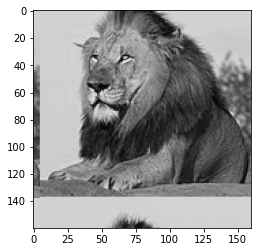

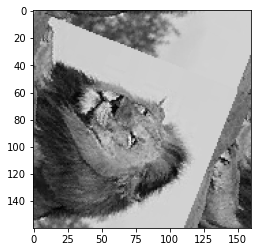

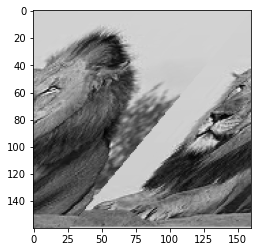

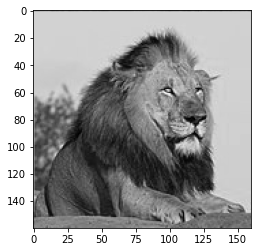

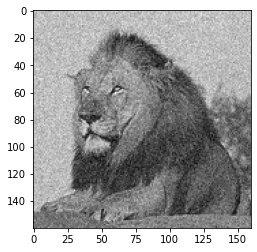

In [148]:
# Plot the translated image
def show(translated_image):
    plt.imshow(translated_image, cmap='gray')
    plt.show()

# Load lion image for testing
lion = imread('lion.png')

# Display each transformation of lion
show(translate(lion, 50, 50))
show(rotate(lion, 2*np.pi))
show(skew(lion, 1))
show(flip_horizontal(lion))
show(gauss_noise(lion, 20))

<h3 align="center"> Problem 2 </h3>
Take the sklearn digits dataset, make an 80-20 train-test split, then apply 
each of your transformations to the entire training set. You must decide good 
values of each of the parameters to use---justify each choice.
This should give you a larger (augmented) training set with roughly 8,600 
training points. Fit a random forest to the augmented training set and to the 
original training set and return the results of each on the test set. 

In [149]:
def image_augment(X,Y,parameters):
    """ transform the images using the functions above. 
    Parameters:
        X (N,d1,d2): array containing N images of dimension d1 x d2
        Y (N,): Labels/values for each image
        parameters: List of parameter values [A,B,theta,A,sigma2]
    Returns:
        augmented_X (6N,d1,d2): original and transformed data in one array 
        augmented_Y (6N): corresponding labels/values
    """
    A,B,theta,A2,sigma2 = parameters
    # Make copies of X, Y
    images = X
    labels = Y
    
    # Iterate through each image in X and apply transformations from prob1
    for i in range(len(X)):
        trans = translate(images[i], A, B)
        rot = rotate(images[i], theta)
        sk = skew(images[i], A2)
        fl = flip_horizontal(images[i])
        gau = gauss_noise(images[i], sigma2)
        X = np.append(X,[trans,rot,sk,fl,gau], axis=None)
        label = [labels[i]]
        Y = np.append(Y,[label,label,label,label,label], axis=None)
        
    return X, Y


In [226]:
# Load digits dataset
digits = datasets.load_digits()
n_samples = len(digits.images)
images = digits.images.reshape((n_samples, -1))
labels = digits.target
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.80, test_size=0.20)

# Create RandomForest Classifier 1
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_predicted = forest.predict(X_test)
print('Regular score: ' + str(accuracy_score(y_test, forest_predicted)))

# Create RandomForest Classifier 2
images = digits.images
labels = digits.target
aug_images, aug_labels = image_augment(images, labels, [50,50,2*np.pi,1,2])
aug_images = aug_images.reshape((-1,64))
augX_train, augX_test, augy_train, augy_test = train_test_split(aug_images, aug_labels, train_size=0.80, test_size=0.20)
forest2 = RandomForestClassifier()
forest2.fit(augX_train, augy_train)
forest2_predicted = forest2.predict(X_test)
print('Augmented score: ' + str(accuracy_score(y_test, forest2_predicted)))


Regular score: 0.9666666666666667
Augmented score: 1.0


<h2 align="center">Audio Augmentation</h2>

<h3 align="center"> Problem 3 </h3>
The file music.npy contains the audio time series data from 10 second clips of 150 different songs, with style.npy describing the associated style of ballroom dance. The styles included are Chacha, Foxtrot, Jive, Samba, Rumba, and Waltz. Use train_test_split
from sklearn.model_selection with test_size=.5 to create train and test sets. Create two training sets by augmenting this original training set. Each new augmented
training set will include the original data and the augmented data. For the first, add ambient
noise from the file restaurant-ambience.wav. For the second, use time_stretch.

In [401]:
music = np.load('music.npy')
styles = np.load('styles.npy')
ambient = librosa.load('restaurant-ambience.wav')
ambient = ambient[0]

In [402]:
# First model
X_train, X_test, y_train, y_test = train_test_split(music, styles, test_size=0.5)

In [403]:
# Initialize
music_len = music.shape[1]
ambient_len = ambient.shape[0]
max_index = ambient_len - music_len
rate = np.random.uniform(0,1) # Define a rate at which to speed the music
aug1_music = music
aug2_music = np.zeros((music.shape[0], time_stretch(music[0,:],rate).shape[0]))

for i in range(aug1_music.shape[0]):
    # Augmented model 1 (ambient noise)
    index = np.random.randint(0,max_index) # Randomize which index to start at to add ambient to music
    aug1_music[i,:] = aug1_music[i,:] + ambient[index:index+music_len]
    
    # Augmented model 2 (time_stretch)
    aug2_music[i,:] = time_stretch(music[i,:],rate)

# Augment the original music data with the altered arrays
aug1_music = np.vstack((music, aug1_music))
aug1_styles = np.hstack((styles,styles))
if rate <= 1:
    aug2_music = np.vstack((music, aug2_music[:,0:music.shape[1]]))
else:
    aug2_music = np.vstack((music[:,0:aug2_music.shape[1]], aug2_music))
aug2_styles = aug1_styles

# Split the new augmented datasets into train and test
aug1X_train, aug1X_test, aug1y_train, aug1y_test = train_test_split(aug1_music, aug1_styles, test_size=0.5)
aug2X_train, aug2X_test, aug2y_train, aug2y_test = train_test_split(aug2_music, aug2_styles, test_size=0.5)





<h3 align="center"> Problem 4</h3>

Do the following steps 5 times:

• Use the original data set and the augmented data sets to fit three RandomForestClassifiers,
one only on the original data, one on the original data and the data with ambient noise
added, and one on the original data and the time stretched data.

• Score each classifier.

Print the mean score for each of the classifiers and print the standard deviation for the scores.


In [404]:
orig_pulses = np.apply_along_axis(librosa.beat.plp, 1, music)
amb_pulses = np.apply_along_axis(librosa.beat.plp, 1, aug1_music)
time_pulses = np.apply_along_axis(librosa.beat.plp, 1, aug2_music)

/Users/quindaly/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=384 is too small for input signal of length=216
  n_fft, y.shape[-1]


In [405]:
orig = []
amb = []
time = []
for i in range(5):
    
    # Original Data
    forest = RandomForestClassifier()
    X_train, X_test, y_train, y_test = train_test_split(orig_pulses, styles, test_size=0.5)
    forest.fit(X_train, y_train)
    forest_predicted = forest.predict(X_test)
    orig.append(accuracy_score(y_test, forest_predicted))
    
    # Ambient Data
    forest2 = RandomForestClassifier()
    X_train, aug1X_test, y_train, aug1y_test = train_test_split(amb_pulses, aug1_styles, test_size=0.5)
    forest2.fit(X_train, y_train)
    forest2_predicted = forest2.predict(X_test)
    amb.append(accuracy_score(y_test, forest2_predicted))
    
    # Time_stretch Data
    forest3 = RandomForestClassifier()
    X_train, aug2X_test, y_train, aug2y_test = train_test_split(time_pulses, aug2_styles, test_size=0.5)
    forest3.fit(X_train, y_train)
    forest3_predicted = forest3.predict(X_test)
    time.append(accuracy_score(y_test, forest3_predicted))
    
print('\t\t Mean \t STD')
print('Original:','\t',np.round(np.mean(orig),3),'\t',np.round(np.std(orig),3))
print('Ambient Noise:','\t',np.round(np.mean(amb),3),'\t',np.round(np.std(amb),3))
print('Time Stretch:','\t',np.round(np.mean(time),3),'\t', np.round(np.std(time),3))

		 Mean 	 STD
Original: 	 0.517 	 0.043
Ambient Noise: 	 0.901 	 0.027
Time Stretch: 	 0.755 	 0.043


<h2 align="center">SMOTE</h2>

<h3 align="center"> Problem 5 </h3>

Write a function that uses the synthetic minority oversampling technique to augment an imbalanced data set.
Your function should have the following characteristics:

Accept $X$, a matrix of minority class samples
       $N$, the number of samples to generate per original point
       $k$, the number of nearest neighbors.

For each original point in the sample, pick one of the $k$ nearest neighbors at random and generate a new point that lies between the two original values. 

Return an array containing the synthetic samples.


In [398]:
def smote(X,N,k):
    """ Generate synthetic points using the SMOTE method. Hint! Use KDTree :)
    Parameters:
        X (n,m): minority class samples
        N (int): number of samples to generate from each point
        k (int): number of nearest neighbors
    Returns:
        synthetic ndarray(N*n,m): synthetic minority class samples
    """
    n,m = X.shape
    additional_data = np.zeros(m)
    
    # iterate through each sample
    tree = KDTree(X)
    for i in range(n):
        dist, ind = tree.query(X[i:i+1], k=k) # Find the k nearest neighbors
        # perform SMOTE N times for each sample
        for j in range(N):
            # randomly select one of the neighbors
            choice = np.random.randint(0,k)
            neighbor_index = ind[0][choice]

            new_point = []
            # make a random draw between each feature of the 2 samples
            for feature in range(m):
                new_point.append(np.random.uniform(X[i,feature],X[neighbor_index,feature]))
            additional_data = np.vstack((additional_data,np.array(new_point)))
    
    # Merge the SMOTE data with the original data
    synthetic = additional_data[1:,:]
    
    return synthetic
        

<h3 align="center"> Problem 6 </h3>

The dataset found in creditcard.npy contains information about credit card purchases made over a two day period. 
Of the approximately 285,000 observations, 492 are fraudulent purchases. 
The last column indicates if the purchase was valid (0) or fraudulent (1). 

Do the following steps 10 times:

• Create a training and test set from the data using train_test_split from sklearn.
model_selection with test_size=.7.

• Use smote with N = 500 and k = 2 to augment the training set.

• Create two Gaussian Naïve Bayes classifiers (from sklearn.naive_bayes.GaussianNB),
one which wil be trained on only the original data and the other on the SMOTE augmented
data and the original data.

• Fit each classifier and find the recall and accuracy of each model.

Print the mean recall and mean accuracy of each model and and describe the findings.

In [396]:
df = np.load('creditcard.npy')
N = 500
k = 2

In [399]:
orig_recall = []
orig_score = []
smote_recall = []
smote_score = []
for iterations in range(1):
    
    # Create training and test sets from data
    X_train, X_test, y_train, y_test = train_test_split(df[:,:-1], df[:,-1], test_size=0.7)
    
    # Use smote with N=500 and k=2    
    augmented = smote(X_train[y_train==1],N,k)
    augmented_X = np.vstack((X_train, augmented))
    
    # Fit first model to original
    gauss = GaussianNB()
    gauss.fit(X_train, y_train)
    gauss_predicted = gauss.predict(X_test)
    precision, recall = precision_recall_fscore_support(y_test, gauss_predicted)[:2]
    orig_recall.append(recall[0])
    orig_score.append(precision[0])
    
    
    # Fit second model to augmented
    y_train = np.concatenate((y_train, np.ones(augmented_X.shape[0] - y_train.shape[0])))
    gauss2 = GaussianNB()
    gauss2.fit(augmented_X, y_train)
    gauss2_predicted = gauss.predict(X_test)
    precision, recall = precision_recall_fscore_support(y_test, gauss2_predicted)[:2]
    smote_recall.append(recall[0])
    smote_score.append(precision[0])
        
    

In [400]:
print('\t\t Recall \t Accuracy')
print('Original','\t',np.round(np.mean(orig_recall),5),'\t', np.round(np.mean(orig_score),5))
print('SMOTE', '\t\t', np.round(np.mean(smote_recall),5), '\t', np.round(np.mean(smote_score),5))

		 Recall 	 Accuracy
Original 	 0.99397 	 0.99937
SMOTE 		 0.99397 	 0.99937
